In [191]:
import requests
import base64
import json
import statistics
import matplotlib.pyplot as plt
from collections import Counter
import os

In [96]:
def get_access_code():
    client_id = '##########' #os.environ.get('CLIENT_ID')
    client_secret = '##########' #os.environ.get('CLIENT_SECRET')
    auth_str = "{0}:{1}".format(client_id, client_secret)
    encoded_auth = base64.b64encode(auth_str.encode()).decode()
    headers = {"Authorization":"Basic {0}".format(encoded_auth)}
    base_url = 'https://accounts.spotify.com'
    request_body = {'grant_type': 'client_credentials'}
    response = requests.post("{0}/api/token".format(base_url), headers = headers, data = request_body)
    return response.text

In [161]:
access_code = get_access_code()

In [162]:
decoded = json.loads(access_code)
access_token = decoded['access_token']
# print(access_token)

In [173]:
def get_audio_analysis(track_id):
    base_url = "https://api.spotify.com/v1/audio-analysis"
    headers = {"Authorization": "Bearer {0}".format(access_token)}
    response = requests.get("{0}/{1}".format(base_url, track_id), headers = headers)
    return json.loads(response.text)

def get_audio_features(track_ids_list):
    ids_string = ','.join(track_ids_list)
    base_url = "https://api.spotify.com/v1/audio-features"
    headers = {"Authorization": "Bearer {0}".format(access_token)}
    response = requests.get("{0}/?ids={1}".format(base_url, ids_string), headers = headers)
    return json.loads(response.text)

def get_playlist(playlist_id):
    base_url = "https://api.spotify.com/v1/playlists"
    headers = {"Authorization": "Bearer {0}".format(access_token)}
    response = requests.get("{0}/{1}/tracks".format(base_url, playlist_id), headers = headers)
    return json.loads(response.text)

In [185]:
def remove_dups(list_with_dups):
    freq_map = Counter(list_with_dups)
    ret = []
    for elem, count in freq_map.items():
        if count == 1:
            ret.append(elem)
    return ret

def make_capped_track_id_lists(uncapped_track_id_list):
    song_cap = 50
    number_tracks = len(uncapped_track_id_list)
    
    ret = [uncapped_track_id_list[i: i + song_cap] for i in range(0, number_tracks, song_cap)]
    
    return ret

In [186]:
decades_to_playlist_id_map = {
    'all_out_50s': '37i9dQZF1DWSV3Tk4GO2fq',
    'all_out_60s': '37i9dQZF1DXaKIA8E7WcJj', 
    'all_out_70s': '37i9dQZF1DWTJ7xPn4vNaz',
    'all_out_80s': '37i9dQZF1DX4UtSsGT1Sbe',
    'all_out_90s': '37i9dQZF1DXbTxeAdrVG2l',
    'all_out_00s': '37i9dQZF1DX4o1oenSJRJd',
    'all_out_10s': '37i9dQZF1DX5Ejj0EkURtP'
}

decades_to_track_ids_map = {}
for decade in decades_to_playlist_id_map:
    decades_to_track_ids_map[decade] = []

# track_ids_to_decades_map = {}
    
uncapped_track_id_list = []

for decade in decades_to_playlist_id_map:
    tracks_list = get_playlist(decades_to_playlist_id_map[decade])
    for track in tracks_list['items']:
        uncapped_track_id_list.append(track['track']['id'])
        decades_to_track_ids_map[decade].append(track['track']['id'])
#         track_ids_to_decades_map[track['track']['id']] = decade

distinct_id_list = remove_dups(uncapped_track_id_list)
capped_lists = make_capped_track_id_lists(distinct_id_list)

track_id_to_data_map = {}
for capped in capped_lists:
    audio_features = get_audio_features(capped)
    for track in audio_features['audio_features']:
        track_id_to_data_map[track['id']] = track.copy()

In [206]:
decades_list = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

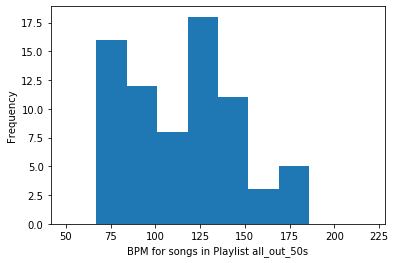

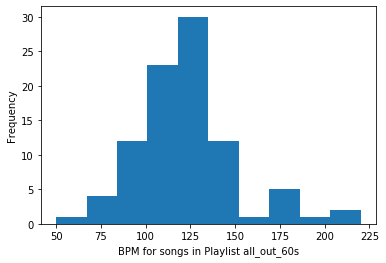

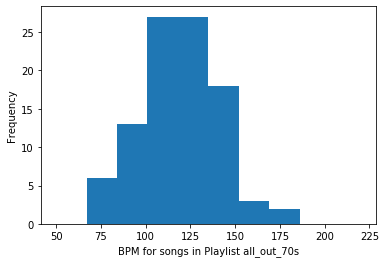

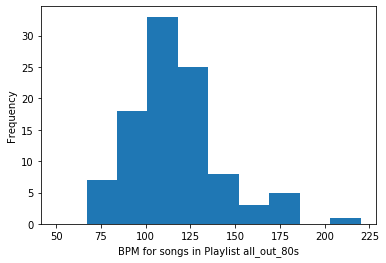

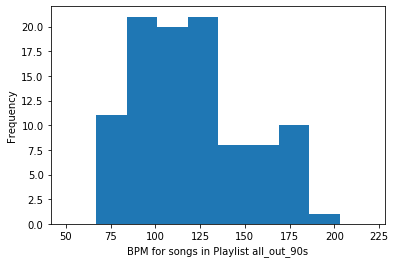

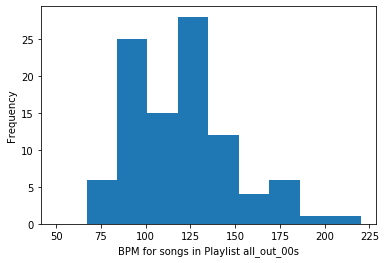

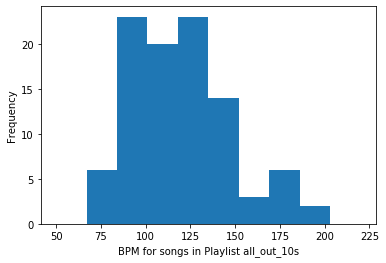

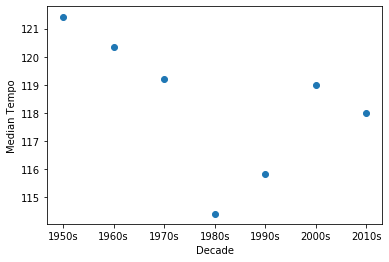

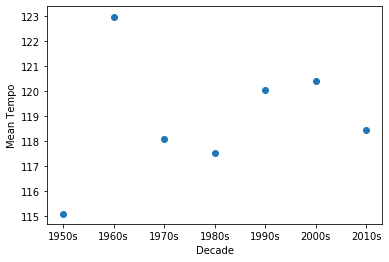

In [217]:
feature = 'tempo'

median_list = []
mean_list = []
for decade, track_list in decades_to_track_ids_map.items():
    data_list = []
    for track in track_list:
        if track in track_id_to_data_map:
            data_list.append(track_id_to_data_map[track][feature])
    median_list.append(statistics.median(data_list))
    mean_list.append(statistics.mean(data_list))
    plt.hist(data_list, range = (50, 220))
    plt.xlabel("BPM for songs in Playlist {0}".format(decade))
    plt.ylabel("Frequency")
    plt.savefig("graphs/{0}_BPM_distribution.png".format(decade))
    plt.show()
    
plt.scatter(range(7), median_list)
plt.xticks(ticks = range(7), labels = decades_list)
plt.xlabel('Decade')
plt.ylabel('Median Tempo')
plt.savefig("graphs/median_tempo_over_time.png")
plt.show()

plt.scatter(range(7), mean_list)
plt.xticks(ticks = range(7), labels = decades_list)
plt.xlabel('Decade')
plt.ylabel('Mean Tempo')
plt.savefig("graphs/mean_tempo_over_time.png")
plt.show()

In [228]:
def plot_stratified_and_overall(feat_x, feat_y):
    over_x = []
    over_y = []
    decade_color = 0
    colors = []
    for decade, track_list in decades_to_track_ids_map.items():
        strat_x = []
        strat_y = []
        for track in track_list:
            if track in track_id_to_data_map:
                track_data = track_id_to_data_map[track]
                over_x.append(track_data[feat_x])
                strat_x.append(track_data[feat_x])
                over_y.append(track_data[feat_y])
                strat_y.append(track_data[feat_y])
                colors.append(decade_color)
        plt.scatter(strat_x, strat_y)
        plt.xlabel(feat_x)
        plt.ylabel(feat_y)
        plt.title(decade)
        plt.savefig("graphs/{0}_vs_{1}_decade_{2}.png".format(feat_y, feat_x, decade))
        plt.show()
        decade_color += 1
    plt.scatter(over_x, over_y, c = colors)
    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.savefig("graphs/{0}_vs_{1}_overall.png".format(feat_y, feat_x))
    plt.show()

def plot_3_subplots(feat_x1, feat_y1, feat_x2, feat_y2, feat_x3, feat_y3):
    data_x1 = []
    data_y1 = []
    data_x2 = []
    data_y2 = []
    data_x3 = []
    data_y3 = []
    
    decade_color = 0
    
    colors = []
    
    for decade, track_list in decades_to_track_ids_map.items():
        for track in track_list:
            if track in track_id_to_data_map:
                track_data = track_id_to_data_map[track]
                
                data_x1.append(track_data[feat_x1])
                data_x2.append(track_data[feat_x2])
                data_y1.append(track_data[feat_y1])
                data_y2.append(track_data[feat_y2])
                data_x3.append(track_data[feat_x3])
                data_y3.append(track_data[feat_y3])
                
                colors.append(decade_color)
        decade_color += 1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)
    ax1.scatter(data_x1, data_y1, c = colors)
    ax1.set_xlabel(feat_x1)
    ax1.set_ylabel(feat_y1)
    ax2.scatter(data_x2, data_y2, c = colors)
    ax2.set_xlabel(feat_x2)
    ax2.set_ylabel(feat_y2)
    ax3.scatter(data_x3, data_y3, c = colors)
    ax3.set_xlabel(feat_x3)
    ax3.set_ylabel(feat_y3)
    fig.savefig("graphs/{0}_vs{1}--{2}_vs_{3}--{4}_vs_{5}.png".format(feat_y1, feat_x1, feat_y2, feat_x2, feat_y3, feat_x3))
    fig.show()

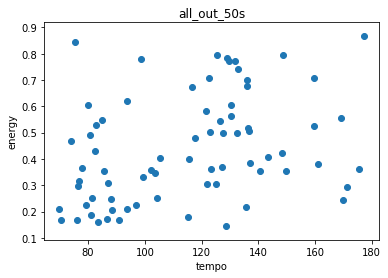

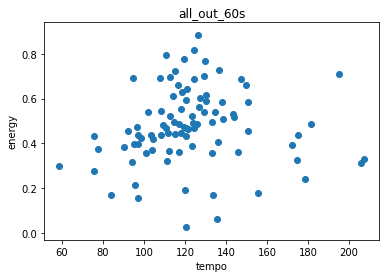

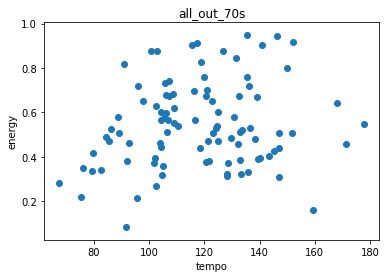

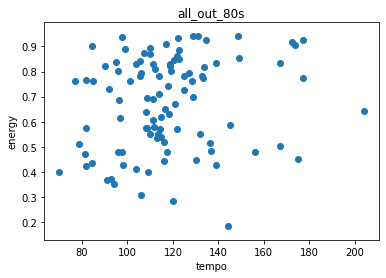

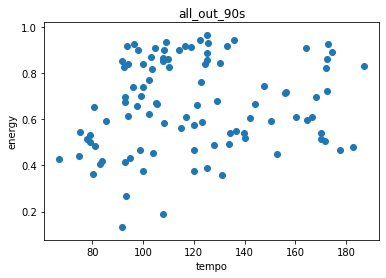

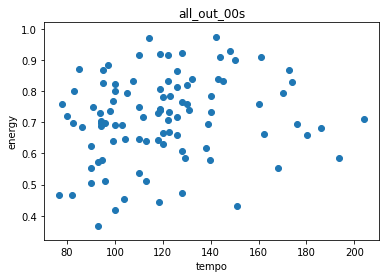

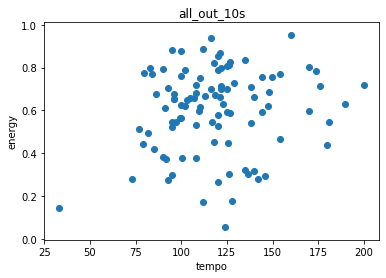

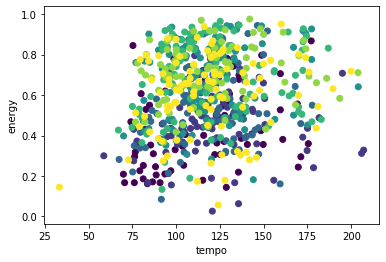

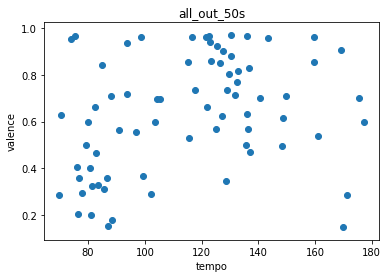

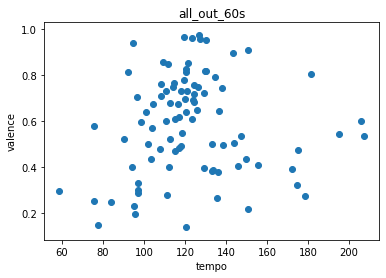

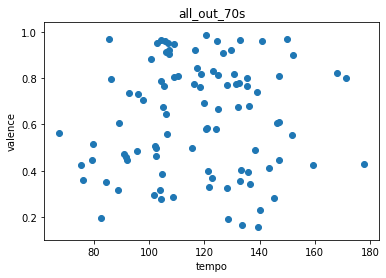

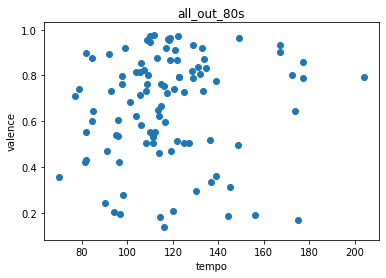

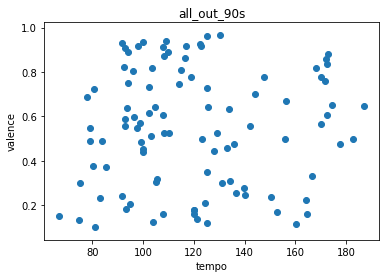

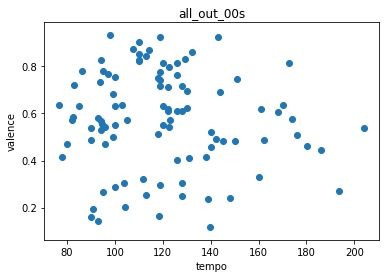

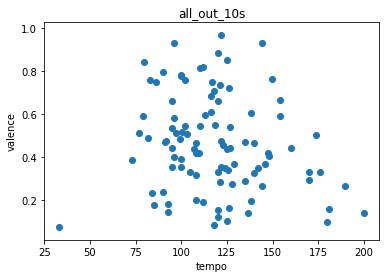

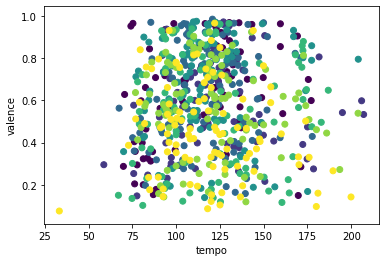

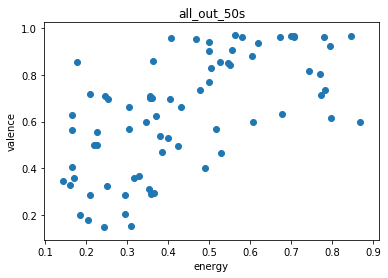

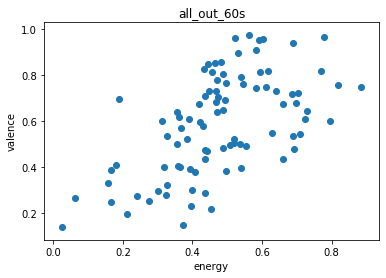

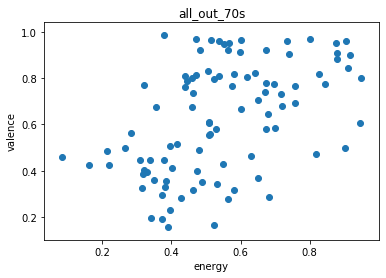

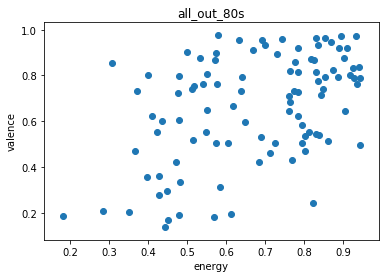

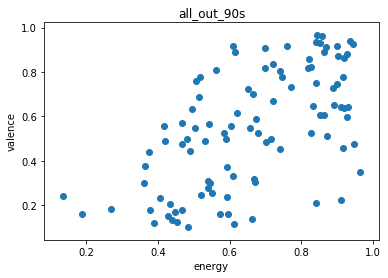

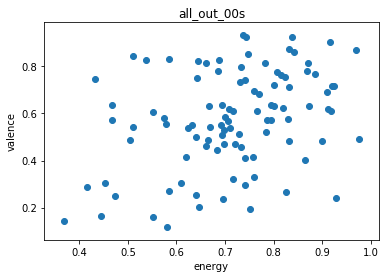

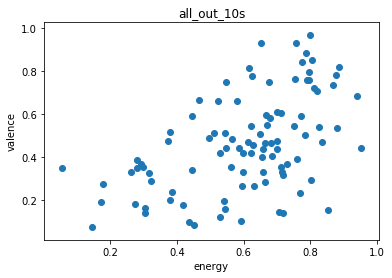

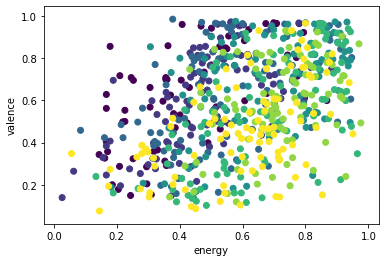

/Users/bridgettelafaye/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


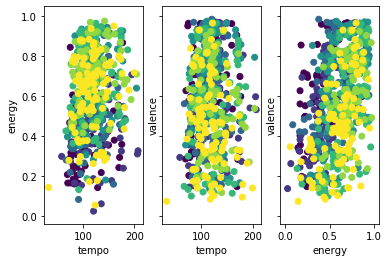

In [229]:
feature_x = 'tempo'

feature_y = 'energy'

plot_stratified_and_overall(feature_x, feature_y)

feature_y = 'valence'

plot_stratified_and_overall(feature_x, feature_y)

feature_x = 'energy'

plot_stratified_and_overall(feature_x, feature_y)

plot_3_subplots('tempo', 'energy', 'tempo', 'valence', 'energy', 'valence')